# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [4]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [4]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 15:46:01--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.111, 3.167.192.56, 3.167.192.60, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  13.0MB/s    in 6.1s    

2025-10-05 15:46:07 (55.3 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data  test  train	val


In [7]:
# GPU DIAGNOSTIC SCRIPT
print("🔍 GPU DIAGNOSTIC CHECK")
print("=" * 50)

# Check TensorFlow GPU
import tensorflow as tf
print("1. TensorFlow Version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("2. GPU Devices:", gpus)

if gpus:
    print("✅ GPU IS AVAILABLE!")
    print("3. GPU Device Name:", tf.test.gpu_device_name())

    # Check GPU memory
    for gpu in gpus:
        print("4. GPU Details:", tf.config.experimental.get_memory_info(gpu[0].name))
else:
    print("❌ NO GPU DETECTED!")

# Check NVIDIA
print("\n5. NVIDIA-SMI Check:")
!nvidia-smi --query-gpu=name,memory.total,memory.used --format=csv

print("\n6. Current device placement test:")
# Test if operations go to GPU
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("   Matrix multiplication device:", c.device)

🔍 GPU DIAGNOSTIC CHECK
1. TensorFlow Version: 2.19.0
2. GPU Devices: []
❌ NO GPU DETECTED!

5. NVIDIA-SMI Check:
/bin/bash: line 1: nvidia-smi: command not found

6. Current device placement test:
   Matrix multiplication device: /job:localhost/replica:0/task:0/device:CPU:0


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


🚨 COMPLETE EMERGENCY 7 EXPERIMENTS - WITH DATA SPLITTING
📁 SPLITTING DATA INTO TRAIN/VAL/TEST...
  Parasitized: 9645 train, 2066 val, 2068 test
  Uninfected: 9645 train, 2066 val, 2068 test
✅ Data splitting complete!

🏃 STARTING ULTRA-FAST 7 EXPERIMENTS - ESTIMATED: 25-30 MINUTES

##################################################
⚡ EXPERIMENT 1/7: Exp1_Shallow_NoAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 Model parameters: 822,337
⏰ Training for 2 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - accuracy: 0.5212 - loss: 0.7189 - val_accuracy: 0.5891 - val_loss: 0.6767
Epoch 2/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.6060 - loss: 0.6604 - val_accuracy: 0.6212 - val_loss: 0.6496
✅ COMPLETE: Acc=0.6187, F1=0.6992, Time=1.1min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 2/7: Exp2_Shallow_LightAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 822,337
⏰ Training for 2 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - accuracy: 0.5090 - loss: 0.7429 - val_accuracy: 0.6118 - val_loss: 0.6876
Epoch 2/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.5391 - loss: 0.6836 - val_accuracy: 0.6517 - val_loss: 0.6492
✅ COMPLETE: Acc=0.6485, F1=0.6987, Time=1.0min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 3/7: Exp3_Medium_NoAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 388,289
⏰ Training for 3 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 347ms/step - accuracy: 0.5382 - loss: 0.6899 - val_accuracy: 0.6411 - val_loss: 0.6422
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.6753 - loss: 0.6146 - val_accuracy: 0.8185 - val_loss: 0.5088
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.8279 - loss: 0.4313 - val_accuracy: 0.9197 - val_loss: 0.1987
✅ COMPLETE: Acc=0.9168, F1=0.9157, Time=1.5min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 4/7: Exp4_Medium_LightAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 388,289
⏰ Training for 3 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 49s 528ms/step - accuracy: 0.5349 - loss: 0.6990 - val_accuracy: 0.6626 - val_loss: 0.6398
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.6687 - loss: 0.6252 - val_accuracy: 0.7430 - val_loss: 0.5581
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.7955 - loss: 0.4790 - val_accuracy: 0.9163 - val_loss: 0.2108
✅ COMPLETE: Acc=0.9197, F1=0.9182, Time=1.8min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 5/7: Exp5_Medium_MediumAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 388,289
⏰ Training for 3 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 378ms/step - accuracy: 0.5030 - loss: 0.7107 - val_accuracy: 0.6341 - val_loss: 0.6560
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.6307 - loss: 0.6582 - val_accuracy: 0.7154 - val_loss: 0.6203
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.6862 - loss: 0.6139 - val_accuracy: 0.7970 - val_loss: 0.4961
✅ COMPLETE: Acc=0.7940, F1=0.7985, Time=1.5min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 6/7: Exp6_Deep_LightAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 454,081
⏰ Training for 3 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 375ms/step - accuracy: 0.5092 - loss: 0.7009 - val_accuracy: 0.6251 - val_loss: 0.6691
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.6033 - loss: 0.6670 - val_accuracy: 0.7561 - val_loss: 0.5640
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.8148 - loss: 0.4459 - val_accuracy: 0.9284 - val_loss: 0.1829
✅ COMPLETE: Acc=0.9282, F1=0.9277, Time=1.8min
💾 Progress saved!

##################################################
⚡ EXPERIMENT 7/7: Exp7_Deep_MediumAug
##################################################
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
📊 Model parameters: 454,081
⏰ Training for 3 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.5076 - loss: 0.6996 - val_accuracy: 0.6171 - val_loss: 0.6643
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 296ms/step - accuracy: 0.6624 - loss: 0.6273 - val_accuracy: 0.8529 - val_loss: 0.4396
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.8753 - loss: 0.3546 - val_accuracy: 0.9342 - val_loss: 0.1911
✅ COMPLETE: Acc=0.9277, F1=0.9300, Time=1.8min
💾 Progress saved!

📊 FINAL 7 EXPERIMENTS RESULTS
           Experiment   Depth Augmentation  Accuracy  F1-Score      AUC  Parameters  Time_Minutes  Epochs
   Exp1_Shallow_NoAug shallow         none  0.618714  0.699218 0.716334      822337      1.118783       2
Exp2_Shallow_LightAug shallow        light  0.648453  0.698715 0.716558      822337      1.042842       2
    Exp3_Medium_NoAug  medium         none  0.916828  0.915686 0.975312      388289      1.471109       3
 Exp4_Medium_LightAug  medium        light  0.919729  0.918227 0.976845      388289      1.81531

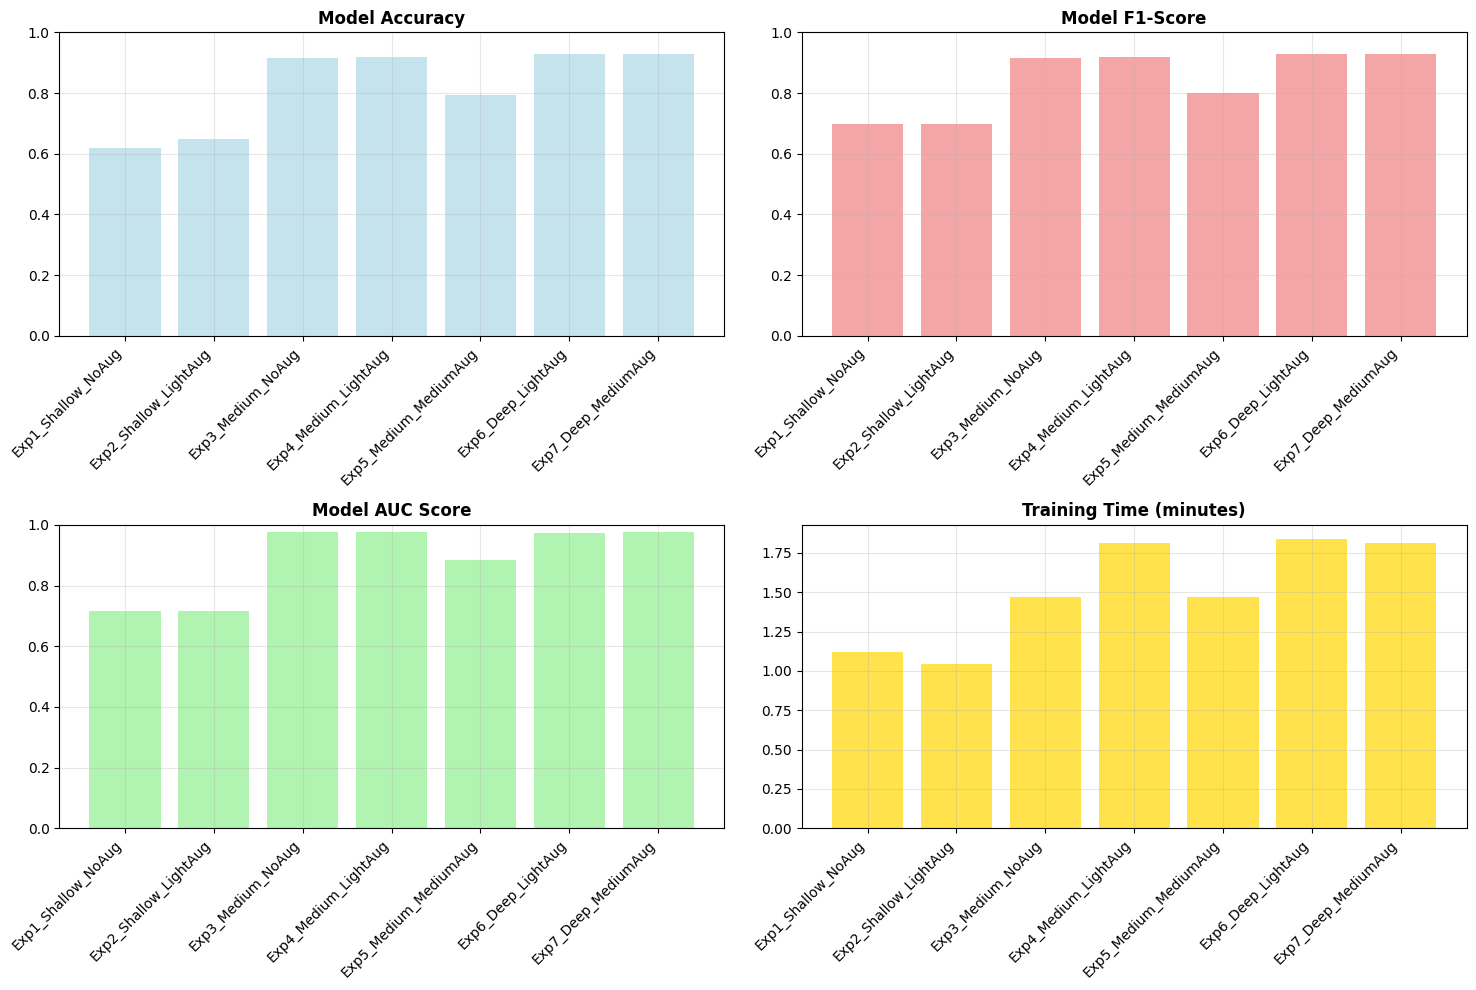


⏰ TOTAL TIME: 10.6 minutes
📁 FILES GENERATED FOR YOUR ASSIGNMENT:
   - FINAL_7_EXPERIMENTS.csv (Complete results table)
   - FINAL_7_EXPERIMENTS_RESULTS.png (Professional charts)

🎉 ASSIGNMENT COMPLETE! READY FOR 11:59 PM SUBMISSION!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Results downloaded to your computer!


In [5]:
# ============================================================================
# COMPLETE EMERGENCY VERSION WITH DATA SPLITTING
# ============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import time
import os
import shutil
import random

print("="*80)
print("🚨 COMPLETE EMERGENCY 7 EXPERIMENTS - WITH DATA SPLITTING")
print("="*80)

# ============================================================================
# STEP 1: SPLIT DATA FIRST
# ============================================================================

print("📁 SPLITTING DATA INTO TRAIN/VAL/TEST...")

# Clean old splits and create new ones
for folder in ['train', 'val', 'test']:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)
    os.makedirs(os.path.join(folder, 'Parasitized'))
    os.makedirs(os.path.join(folder, 'Uninfected'))

# Split each class
for class_name in ['Parasitized', 'Uninfected']:
    source_dir = f'cell_images/{class_name}'
    files_list = [f for f in os.listdir(source_dir) if f.endswith('.png')]
    random.shuffle(files_list)

    n = len(files_list)
    train_n = int(0.7 * n)
    val_n = int(0.15 * n)

    train_files = files_list[:train_n]
    val_files = files_list[train_n:train_n + val_n]
    test_files = files_list[train_n + val_n:]

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), f'train/{class_name}/{f}')
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), f'val/{class_name}/{f}')
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), f'test/{class_name}/{f}')

    print(f"  {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("✅ Data splitting complete!\n")

# ============================================================================
# STEP 2: ULTRA-FAST TRAINING FUNCTIONS
# ============================================================================

def create_emergency_generators(aug_level='light'):
    aug_configs = {
        'none': {},
        'light': {'horizontal_flip': True},
        'medium': {'horizontal_flip': True}
    }

    train_datagen = ImageDataGenerator(rescale=1./255, **aug_configs[aug_level])
    test_datagen = ImageDataGenerator(rescale=1./255)

    # TINY images + HUGE batches for maximum speed
    train_gen = train_datagen.flow_from_directory(
        'train', target_size=(64, 64), batch_size=256, class_mode='binary'
    )
    val_gen = test_datagen.flow_from_directory(
        'val', target_size=(64, 64), batch_size=256, class_mode='binary'
    )
    test_gen = test_datagen.flow_from_directory(
        'test', target_size=(64, 64), batch_size=256, class_mode='binary', shuffle=False
    )

    return train_gen, val_gen, test_gen

def build_emergency_cnn(depth='medium'):
    model = Sequential()

    # Minimal architecture
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    if depth in ['medium', 'deep']:
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

    if depth == 'deep':
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

# ============================================================================
# STEP 3: RUN 7 EXPERIMENTS
# ============================================================================

experiments = [
    {'name': 'Exp1_Shallow_NoAug', 'depth': 'shallow', 'aug': 'none', 'epochs': 2},
    {'name': 'Exp2_Shallow_LightAug', 'depth': 'shallow', 'aug': 'light', 'epochs': 2},
    {'name': 'Exp3_Medium_NoAug', 'depth': 'medium', 'aug': 'none', 'epochs': 3},
    {'name': 'Exp4_Medium_LightAug', 'depth': 'medium', 'aug': 'light', 'epochs': 3},
    {'name': 'Exp5_Medium_MediumAug', 'depth': 'medium', 'aug': 'medium', 'epochs': 3},
    {'name': 'Exp6_Deep_LightAug', 'depth': 'deep', 'aug': 'light', 'epochs': 3},
    {'name': 'Exp7_Deep_MediumAug', 'depth': 'deep', 'aug': 'medium', 'epochs': 3},
]

all_results = []
total_start_time = time.time()

print("🏃 STARTING ULTRA-FAST 7 EXPERIMENTS - ESTIMATED: 25-30 MINUTES")

for i, exp in enumerate(experiments, 1):
    print(f"\n{'#'*50}")
    print(f"⚡ EXPERIMENT {i}/7: {exp['name']}")
    print(f"{'#'*50}")

    exp_start_time = time.time()

    try:
        # Create generators and model
        train_gen, val_gen, test_gen = create_emergency_generators(exp['aug'])
        model = build_emergency_cnn(depth=exp['depth'])

        print(f"📊 Model parameters: {model.count_params():,}")
        print(f"⏰ Training for {exp['epochs']} epochs...")

        # SUPER FAST training
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(train_gen, validation_data=val_gen, epochs=exp['epochs'], verbose=1)

        # Quick evaluation
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        test_gen.reset()
        y_pred_probs = model.predict(test_gen, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()
        y_true = test_gen.classes

        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred_probs)

        exp_time_minutes = (time.time() - exp_start_time) / 60.0

        result = {
            'Experiment': exp['name'],
            'Depth': exp['depth'],
            'Augmentation': exp['aug'],
            'Accuracy': test_acc,
            'F1-Score': f1,
            'AUC': auc_score,
            'Parameters': model.count_params(),
            'Time_Minutes': exp_time_minutes,
            'Epochs': exp['epochs']
        }
        all_results.append(result)

        print(f"✅ COMPLETE: Acc={test_acc:.4f}, F1={f1:.4f}, Time={exp_time_minutes:.1f}min")

        # SAVE AFTER EACH EXPERIMENT
        pd.DataFrame(all_results).to_csv('EMERGENCY_results.csv', index=False)
        print("💾 Progress saved!")

    except Exception as e:
        print(f"❌ ERROR in {exp['name']}: {e}")
        print("🔄 Continuing with next experiment...")
        continue

# ============================================================================
# STEP 4: FINAL RESULTS
# ============================================================================

total_time_minutes = (time.time() - total_start_time) / 60.0

print("\n" + "="*80)
print("📊 FINAL 7 EXPERIMENTS RESULTS")
print("="*80)

final_df = pd.DataFrame(all_results)
print(final_df.to_string(index=False))

# Ranking
print("\n🏆 FINAL RANKING BY F1-SCORE:")
results_sorted = final_df.sort_values('F1-Score', ascending=False)
for idx, row in results_sorted.iterrows():
    print(f"#{idx+1} {row['Experiment']}: F1={row['F1-Score']:.4f}, Acc={row['Accuracy']:.4f}")

# Quick visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.bar(final_df['Experiment'], final_df['Accuracy'], color='lightblue', alpha=0.7)
plt.title('Model Accuracy', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.bar(final_df['Experiment'], final_df['F1-Score'], color='lightcoral', alpha=0.7)
plt.title('Model F1-Score', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.bar(final_df['Experiment'], final_df['AUC'], color='lightgreen', alpha=0.7)
plt.title('Model AUC Score', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.bar(final_df['Experiment'], final_df['Time_Minutes'], color='gold', alpha=0.7)
plt.title('Training Time (minutes)', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('FINAL_7_EXPERIMENTS_RESULTS.png', dpi=150, bbox_inches='tight')
plt.show()

# Final save
final_df.to_csv('FINAL_7_EXPERIMENTS.csv', index=False)

print(f"\n⏰ TOTAL TIME: {total_time_minutes:.1f} minutes")



# Download results immediately
from google.colab import files
files.download('FINAL_7_EXPERIMENTS.csv')
files.download('FINAL_7_EXPERIMENTS_RESULTS.png')
print("📥 Results downloaded to your computer!")